1. load input image and user edit prompt
2. operate VLM (Qwen to extract the parameters): id, class, bbox, matrix.
3. operate SAM to extract the binary mask
4. operate open-CV to to compute the shape mask.
5. operate SDL drawer with shape mask

# PART I - REASONING WITH VLMs

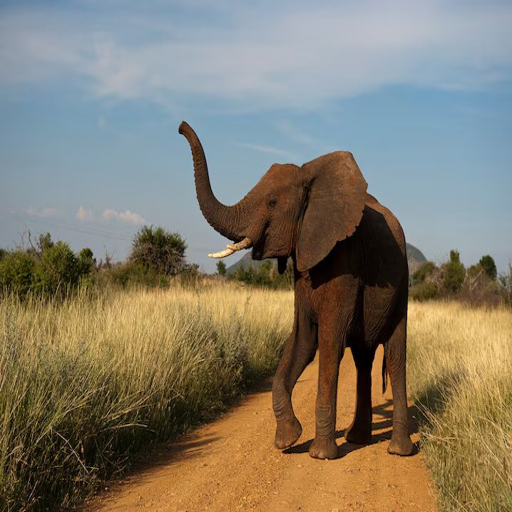

Text(value='', description='Edit Command:', placeholder='Enter your prompt here')

/dtu/blackhole/14/189044/marscho/cache/tmp/ipykernel_2957163/2925245398.py:36: DeprecationWarning: on_submit is deprecated. Instead, set the .continuous_update attribute to False and observe the value changing with: mywidget.observe(callback, 'value').
  user_prompt_widget.on_submit(print_user_prompt)


In [18]:

# Fixed image path
IMG_PATH = "/dtu/blackhole/14/189044/marscho/VLM_controller_for_SD/src/SLD_main_bak/demo/image_editing/src_image_marco/elephant_resized.png"

########################################################################################################################

# 1. load inputs (source image and user prompt)

import ipywidgets as widgets
from IPython.display import display, Image as IPImage
from PIL import Image


# Load the image using PIL
try:
    source_image = Image.open(IMG_PATH)
    # Display the image inline in the notebook
    display(IPImage(filename=IMG_PATH))
except FileNotFoundError:
    print("File not found. Please check the path and try again.")

# Create a text box widget for the user prompt
user_prompt_widget = widgets.Text(
    description='Edit Command:',
    placeholder='Enter your prompt here'
)

# Display the widget
display(user_prompt_widget)

# Function to print the user prompt
def print_user_prompt(change):
    user_prompt = user_prompt_widget.value
    print(f"User prompt: {user_prompt}")

# Attach the function to the user prompt widget to trigger on 'submit'
user_prompt_widget.on_submit(print_user_prompt)

### 1- Parsing Image Attributes (with VLM)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu.


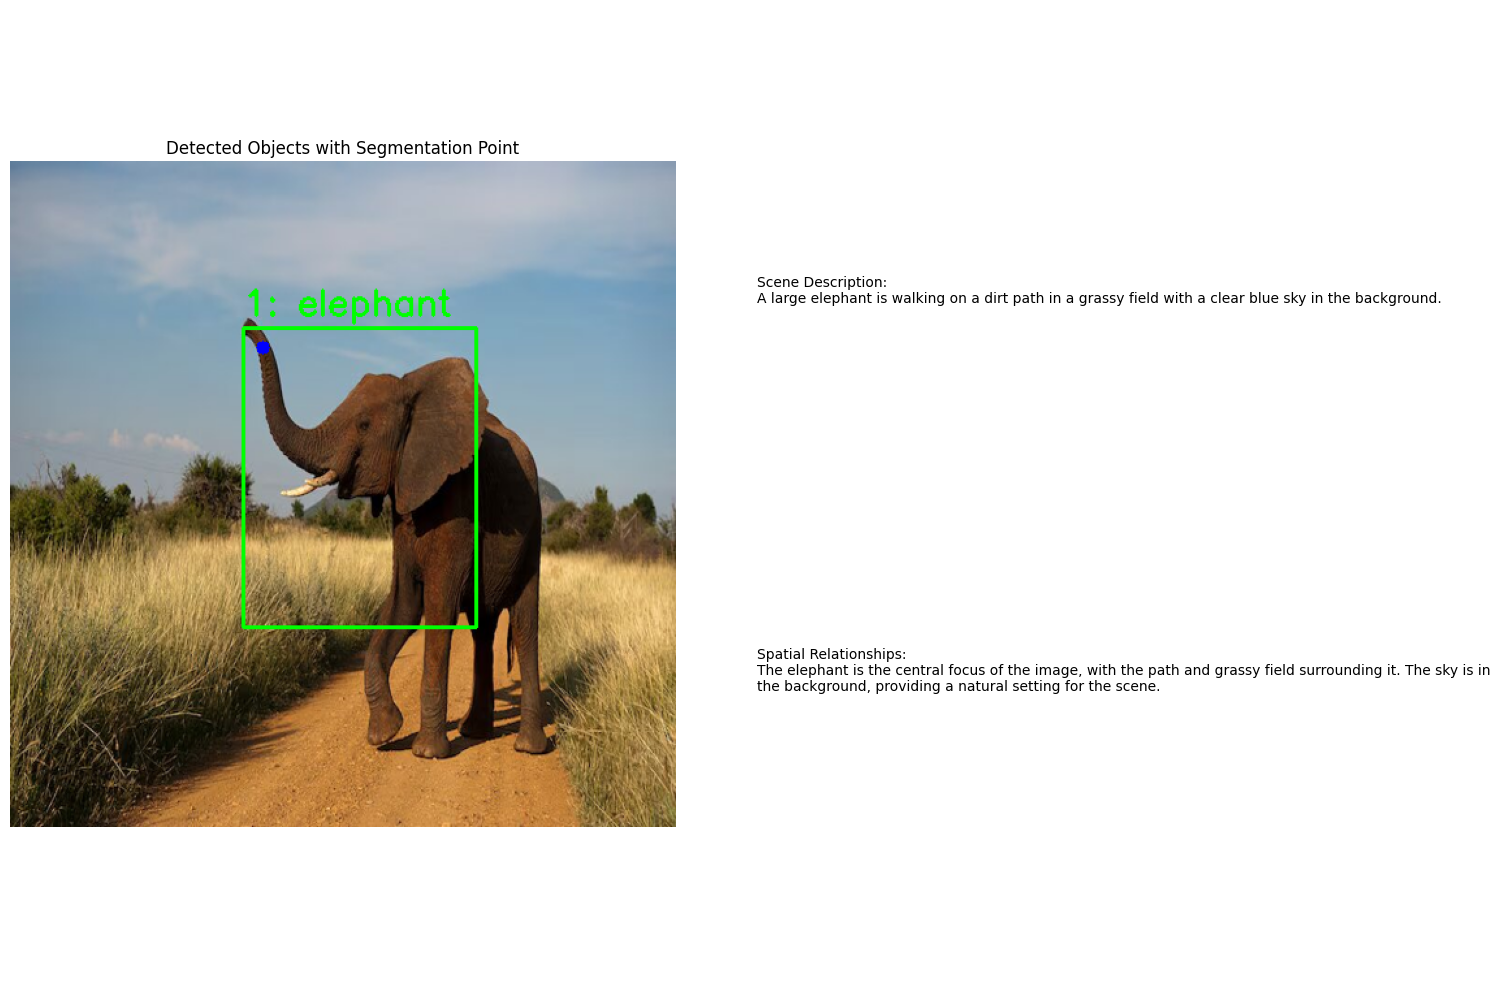


=== DETECTION RESULTS ===

Detected Objects:
Object 1:
  Class: elephant
  Bounding Box (normalized): xmin=0.350, ymin=0.250, xmax=0.700, ymax=0.700
  Segmentation Point: (0.380, 0.280)

Scene Description:
A large elephant is walking on a dirt path in a grassy field with a clear blue sky in the background.

Spatial Relationships:
The elephant is the central focus of the image, with the path and grassy field surrounding it. The sky is in the background, providing a natural setting for the scene.



True

In [21]:
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info
import torch
import cv2
import matplotlib.pyplot as plt
import os
import re

if not os.path.exists(IMG_PATH):
    raise FileNotFoundError(f"Image file not found at {IMG_PATH}")

model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-7B-Instruct",
    torch_dtype=torch.bfloat16,
    device_map="auto",
)
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct")

messages = [
    {
        "role": "system",
        "content": """You are a computer vision expert specializing in object detection, scene understanding and spatial relationships.
For each detected object in the image, output exactly one line in the following format:
DETECT: <object_id>|<object_class>|<xmin>|<ymin>|<xmax>|<ymax>

Then, for each object, identify one point that lies within the head or main focal part of the object in the format:
POINTS: <object_id>|<x>|<y>

Then, provide a scene analysis in the following format:
SCENE: <scene_description>

Finally, describe spatial relationships between objects:
SPATIAL: <spatial_relationships>

Where:
- <object_id> is a sequential number starting from 1
- <object_class> is the specific object category including attributes (color, size, etc)
- <xmin>,<ymin>,<xmax>,<ymax> are normalized coordinates (0-1) for the bounding box
- <x>,<y> are normalized coordinates (0-1) for a point that lies within the object's head/main part
- <scene_description> describes the overall context and setting
- <spatial_relationships> describes how objects relate to each other in space

Ensure the point is always within the head or main focal part of each object for accurate segmentation."""
    },
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": IMG_PATH
            },
            {
                "type": "text", 
                "text": "Analyze this image, detect the main objects, provide a point within the head/main part of each object for segmentation, describe the scene and spatial relationships between objects."
            }
        ]
    }
]

text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
image_inputs, video_inputs = process_vision_info(messages)

inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
).to("cuda")

generated_ids = model.generate(**inputs, max_new_tokens=256)
generated_ids_trimmed = [
    out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)[0]

# Parse the detection and scene understanding output
def parse_model_output(output_text):
    objects = []  # Will store both bbox and point for each object
    scene_desc = ""
    spatial_rel = ""
    
    for line in output_text.split('\n'):
        line = line.strip()
        if line.startswith('DETECT:'):
            _, detection = line.split(':', 1)
            obj_id, obj_class, xmin, ymin, xmax, ymax = detection.strip().split('|')
            obj_id = int(obj_id)
            bbox = [float(xmin), float(ymin), float(xmax), float(ymax)]
            # Initialize object entry
            while len(objects) < obj_id:
                objects.append({'class': None, 'bbox': None, 'point': None})
            objects[obj_id-1]['class'] = obj_class
            objects[obj_id-1]['bbox'] = bbox
        elif line.startswith('POINTS:'):
            _, points_data = line.split(':', 1)
            obj_id, x, y = points_data.strip().split('|')
            obj_id = int(obj_id)
            point = (float(x), float(y))
            while len(objects) < obj_id:
                objects.append({'class': None, 'bbox': None, 'point': None})
            objects[obj_id-1]['point'] = point
        elif line.startswith('SCENE:'):
            _, scene_desc = line.split(':', 1)
        elif line.startswith('SPATIAL:'):
            _, spatial_rel = line.split(':', 1)
                
    return objects, scene_desc.strip(), spatial_rel.strip()

objects, scene_desc, spatial_rel = parse_model_output(output_text)

def annotate_image(image, objects):
    height, width = image.shape[:2]
    for i, obj in enumerate(objects):
        if obj['bbox']:
            # Draw bounding box
            xmin, ymin, xmax, ymax = [int(coord * width) if i % 2 == 0 else int(coord * height) 
                                    for i, coord in enumerate(obj['bbox'])]
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
            cv2.putText(image, f"{i+1}: {obj['class']}", (xmin, ymin-10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        
        if obj['point']:
            # Draw point
            x, y = obj['point']
            px = int(x * width)
            py = int(y * height)
            cv2.circle(image, (px, py), 5, (255, 0, 0), -1)
    
    return image

image = cv2.imread(IMG_PATH)
plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
image = annotate_image(image, objects)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Detected Objects with Segmentation Point")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.text(0.1, 0.7, f"Scene Description:\n{scene_desc}", wrap=True)
plt.text(0.1, 0.3, f"Spatial Relationships:\n{spatial_rel}", wrap=True)
plt.axis('off')

plt.tight_layout()
plt.show()

# Create output directory if it doesn't exist
os.makedirs("output", exist_ok=True)

# Print and save results
print("\n=== DETECTION RESULTS ===")
print("\nDetected Objects:")
for i, obj in enumerate(objects):
    if obj['bbox'] is not None:
        print(f"Object {i+1}:")
        print(f"  Class: {obj['class']}")
        print(f"  Bounding Box (normalized): xmin={obj['bbox'][0]:.3f}, ymin={obj['bbox'][1]:.3f}, "
              f"xmax={obj['bbox'][2]:.3f}, ymax={obj['bbox'][3]:.3f}")
        if obj['point']:
            print(f"  Segmentation Point: ({obj['point'][0]:.3f}, {obj['point'][1]:.3f})")

print("\nScene Description:")
print(scene_desc)

print("\nSpatial Relationships:")
print(spatial_rel)
print("\n=====================")

img_name = IMG_PATH.split('/')[-1].split('.')[0]
output_file = f"output/{img_name}_detection.txt"

with open(output_file, 'w') as f:
    f.write("=== DETECTION RESULTS ===\n")
    f.write("\nDetected Objects:\n")
    for i, obj in enumerate(objects):
        if obj['bbox'] is not None:
            f.write(f"Object {i+1}:\n")
            f.write(f"  Class: {obj['class']}\n")
            f.write(f"  Bounding Box (normalized): xmin={obj['bbox'][0]:.3f}, ymin={obj['bbox'][1]:.3f}, "
                   f"xmax={obj['bbox'][2]:.3f}, ymax={obj['bbox'][3]:.3f}\n")
            if obj['point']:
                f.write(f"  Segmentation Point: ({obj['point'][0]:.3f}, {obj['point'][1]:.3f})\n")
    
    f.write("\nScene Description:\n")
    f.write(f"{scene_desc}\n")
    
    f.write("\nSpatial Relationships:\n") 
    f.write(f"{spatial_rel}\n")
    f.write("\n=====================\n")

# Save the annotated image
output_image_path = f"output/{img_name}_annotated.jpg"
cv2.imwrite(output_image_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))


### 2 - SAM gets binary mask

Using points and bbox prompts together:
Points: [[      294.4      263.68]
 [      204.8       179.2]
 [        256       230.4]]
Labels: [1 1 1]
Boxes: [[      151.3      120.58       437.5      406.78]]
Model summary: 566 layers, 80,850,178 parameters, 80,850,178 gradients

image 1/1 /dtu/blackhole/14/189044/marscho/VLM_controller_for_SD/src/SLD_main_bak/demo/image_editing/src_image_marco/elephant_resized.png: 1024x1024 1 0, 1 1, 1 2, 40.3ms
Speed: 2.4ms preprocess, 40.3ms inference, 0.6ms postprocess per image at shape (1, 3, 1024, 1024)


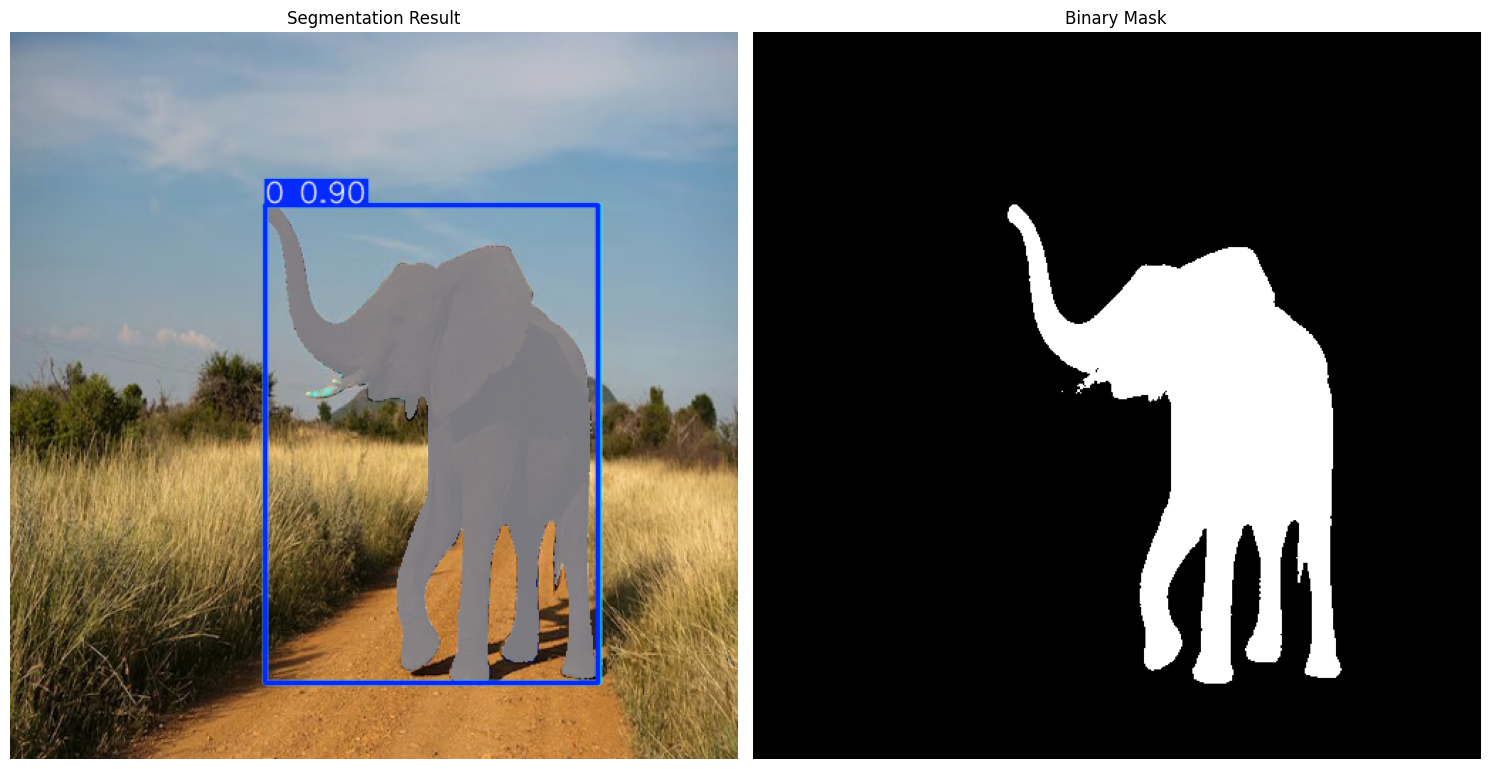

In [22]:
FILE_DESCRIPTION = "output/elephant_detection.txt"   

"""
input: FILE_DESCRIPTION, IMG_PATH
output: masks (segmentation, and binary)
"""

########################################################################################################################


import torch
from sam2.sam2_image_predictor import SAM2ImagePredictor
import numpy as np
from ultralytics import SAM
import matplotlib.pyplot as plt
import cv2
import os

# Create output directory if it doesn't exist
output_dir = 'output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


 
# Parse bounding box coordinates from detection file
with open(FILE_DESCRIPTION, 'r') as f:
    content = f.read()

# Get image dimensions
img = cv2.imread(IMG_PATH)
img_height, img_width = img.shape[:2]

# Extract bounding box coordinates and segmentation points for each object
objects = []
for obj in content.split('Object')[1:]:
    # Check if the object has the required fields
    if 'Class:' in obj and 'Bounding Box (normalized):' in obj:
        class_name = obj.split('Class:')[1].split('\n')[0].strip()
        bbox = obj.split('Bounding Box (normalized):')[1].split('\n')[0].strip()
        
        # Initialize bounding box coordinates
        xmin = ymin = xmax = ymax = None
        
        # Extract bounding box coordinates safely
        for coord in bbox.split(','):
            if 'xmin' in coord:
                xmin = float(coord.split('=')[1].strip())
            elif 'ymin' in coord:
                ymin = float(coord.split('=')[1].strip())
            elif 'xmax' in coord:
                xmax = float(coord.split('=')[1].strip())
            elif 'ymax' in coord:
                ymax = float(coord.split('=')[1].strip())

        # Extract segmentation points
        seg_points = []
        if 'Segmentation Points:' in obj:
            seg_section = obj.split('Segmentation Points:')[1].split('\n')
            for line in seg_section:
                if 'Point' in line and '(' in line:
                    point_str = line.split('(')[1].split(')')[0]
                    x, y = map(float, point_str.split(','))
                    seg_points.append([x * img_width, y * img_height])
        
        # Ensure all coordinates are found before calculating center
        if None not in (xmin, ymin, xmax, ymax):
            # Calculate center point and scale to image dimensions
            center_x = (xmin + xmax) / 2 * img_width
            center_y = (ymin + ymax) / 2 * img_height
            
            # Make bbox 30% bigger
            width = (xmax - xmin) * img_width
            height = (ymax - ymin) * img_height
            
            # Expand by 30% in each direction
            xmin = max(0, xmin * img_width - width * 0.15)
            ymin = max(0, ymin * img_height - height * 0.15)
            xmax = min(img_width, xmax * img_width + width * 0.15)
            ymax = min(img_height, ymax * img_height + height * 0.15)
            
            # Store center, bbox coordinates and segmentation points
            objects.append({
                'class': class_name,
                'center': [center_x, center_y],
                'bbox': [xmin, ymin, xmax, ymax],
                'seg_points': seg_points
            })

# Convert to input format for SAM
input_points = np.array([[obj['center'][0], obj['center'][1]] for obj in objects])
input_labels = np.array([1] * len(objects))  # 1 indicates foreground point
input_boxes = np.array([[obj['bbox'][0], obj['bbox'][1], obj['bbox'][2], obj['bbox'][3]] for obj in objects])

# Add segmentation points to input points and labels
for obj in objects:
    if obj['seg_points']:
        seg_points = np.array(obj['seg_points'])
        input_points = np.vstack([input_points, seg_points])
        input_labels = np.append(input_labels, [1] * len(obj['seg_points']))

print("Using points and bbox prompts together:")
print("Points:", input_points)
print("Labels:", input_labels)
print("Boxes:", input_boxes)

# Load a model
model = SAM("sam2.1_b.pt")

# Display model information (optional)
model.info()

# Run inference with both points and bounding box prompts
results = model(IMG_PATH, points=input_points.tolist(), labels=input_labels.tolist())

# Plot and save the results
for i, r in enumerate(results):
    im_array = r.plot()  # Plot without color argument since it's not supported
    mask_array = r.masks.data[0].cpu().numpy()  # Get binary mask
    
    # Convert BGR to RGB for display
    im_array = im_array[:, :, ::-1]
    # Save segmented image to output directory
    plt.imsave(os.path.join(output_dir, f'{objects[i]["class"]}_segmentation_result_{i}.png'), im_array)
    
    # Save binary mask to output directory
    plt.imsave(os.path.join(output_dir, f'{objects[i]["class"]}_binary_mask_{i}.png'), mask_array, cmap='gray')
    # Create figure with two subplots for display
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
    
    # Plot segmented image
    ax1.imshow(im_array)
    ax1.set_title("Segmentation Result")
    ax1.axis('off')
    
    # Plot binary mask
    ax2.imshow(mask_array, cmap='gray')
    ax2.set_title("Binary Mask")
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()


### 3 - QWEN Math

In [27]:
import re
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer

FILE_DESCRIPTION = "output/elephant_detection.txt"

# Example user edits with clear descriptions
# USER_EDIT = "Scale the object to be twice as large"  # Current active transformation
# USER_EDIT = "Move the object upward by 100 pixels."
# USER_EDIT = "Rotate by 45 degrees clockwise."
USER_EDIT = "Apply a horizontal shear of 0.5 to the object."
# USER_EDIT = "Move the object diagonally up and left by 100 pixels each"
# USER_EDIT = "Move the object left by 100 pixels and rotate it by 90 degrees clockwise."

def parse_detection_file(file_path):
    """Parse detection file and extract object information."""
    with open(file_path, 'r') as f:
        detection_data = f.read()

    objects = []
    pattern = r'Object (\d+):\n\s+Class: (.*?)\n\s+Bounding Box.*?xmin=([\d.]+), ymin=([\d.]+), xmax=([\d.]+), ymax=([\d.]+)'
    
    for match in re.finditer(pattern, detection_data):
        xmin, ymin, xmax, ymax = map(float, match.groups()[2:])
        
        corners = np.array([
            [xmin, ymin, 1],  # top-left
            [xmax, ymin, 1],  # top-right
            [xmax, ymax, 1],  # bottom-right
            [xmin, ymax, 1]   # bottom-left
        ])
        
        obj = {
            'id': int(match.group(1)),
            'class': match.group(2),
            'bbox': [xmin, ymin, xmax, ymax],
            'corners': corners,
            'width': xmax - xmin,
            'height': ymax - ymin,
            'center': [(xmax + xmin)/2, (ymax + ymin)/2]
        }
        objects.append(obj)
    
    return objects

# Define transformation matrices with clear mathematical formulas
class TransformationMatrices:
    @staticmethod
    def translation(tx, ty):
        return np.array([[1, 0, tx],
                        [0, 1, ty],
                        [0, 0, 1]])
    
    @staticmethod
    def rotation(theta):
        return np.array([[np.cos(theta), -np.sin(theta), 0],
                        [np.sin(theta), np.cos(theta), 0],
                        [0, 0, 1]])
    
    @staticmethod
    def scaling(sx, sy):
        return np.array([[sx, 0, 0],
                        [0, sy, 0],
                        [0, 0, 1]])
    
    @staticmethod
    def shear(shx, shy):
        return np.array([[1, shx, 0],
                        [shy, 1, 0],
                        [0, 0, 1]])

def setup_model():
    """Initialize the language model for transformation reasoning."""
    model_name = "Qwen/Qwen2.5-Math-7B-Instruct"
    device = "cuda"
    
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.bfloat16,
        device_map="cuda",
    )
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    return model, tokenizer

def get_transformation_matrix(model, tokenizer, user_edit):
    """Get transformation matrix from model reasoning."""
    messages = [
        {"role": "system", "content": "Integrate natural language reasoning with programs to solve the problem above. Output a 3x3 homogeneous transformation matrices for the following operations:\n\n"
                                    "1. Translation: Moving objects in x,y directions\n"
                                    "   Example: [[1 0 tx][0 1 ty][0 0 1]]\n\n"
                                    "2. Rotation: Rotating objects by angle θ\n"
                                    "   Example: [[cos(θ) -sin(θ) 0][sin(θ) cos(θ) 0][0 0 1]]\n\n"
                                    "3. Scaling: Changing object size\n"
                                    "   Example: [[sx 0 0][0 sy 0][0 0 1]]\n\n"
                                    "4. Shear: Skewing objects\n"
                                    "   Example: [[1 shx 0][shy 1 0][0 0 1]]\n\n"
                                    "5. Combined transformations: Multiple operations at once\n"
                                    "   Example: Translation + Rotation = [[cos(θ) -sin(θ) tx][sin(θ) cos(θ) ty][0 0 1]]\n\n"
                                    # "Output the transformation matrix in format: [h11 h12 h13 h21 h22 h23 h31 h32 h33]. Limit floats to 3 decimals"
                                    },
        {"role": "user", "content": user_edit}
    ]
    
    text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    model_inputs = tokenizer([text], return_tensors="pt").to("cuda")
    
    generated_ids = model.generate(
        **model_inputs,
        max_new_tokens=1024
    )
    generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)]
    
    reasoning = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    
    print("\n=== Model Reasoning ===")
    print(reasoning)
    print("\n=====================")
    
    return parse_matrix_from_reasoning(reasoning)

def parse_matrix_from_reasoning(reasoning):
    """Extract and parse transformation matrix from model reasoning."""
    # Look for matrix pattern in the output format, including LaTeX style matrices
    # Find the output marker first
    output_start = reasoning.find("```output")
    if output_start == -1:
        raise ValueError("Could not find output section in model reasoning")
    
    # Search for matrix patterns after the output marker
    reasoning_after_output = reasoning[output_start:]
    
    matrix_patterns = [
        # Standard array format
        r'\[\s*\[\s*([-+]?\d*\.?\d+)\s*,\s*([-+]?\d*\.?\d+)\s*,\s*([-+]?\d*\.?\d+)\s*\]'
        r'\s*,\s*\[\s*([-+]?\d*\.?\d+)\s*,\s*([-+]?\d*\.?\d+)\s*,\s*([-+]?\d*\.?\d+)\s*\]'
        r'\s*,\s*\[\s*([-+]?\d*\.?\d+)\s*,\s*([-+]?\d*\.?\d+)\s*,\s*([-+]?\d*\.?\d+)\s*\]\s*\]',
        
        # LaTeX style matrix pattern
        r'\\begin{pmatrix}\s*([-+]?\d*\.?\d+/?\d*)\s*&\s*([-+]?\d*\.?\d+/?\d*)\s*&\s*([-+]?\d*\.?\d+/?\d*)\s*\\\\'
        r'\s*([-+]?\d*\.?\d+/?\d*)\s*&\s*([-+]?\d*\.?\d+/?\d*)\s*&\s*([-+]?\d*\.?\d+/?\d*)\s*\\\\'
        r'\s*([-+]?\d*\.?\d+/?\d*)\s*&\s*([-+]?\d*\.?\d+/?\d*)\s*&\s*([-+]?\d*\.?\d+/?\d*)\s*\\end{pmatrix}'
    ]
    
    matrix_values = None
    for pattern in matrix_patterns:
        match = re.search(pattern, reasoning_after_output)
        if match:
            matrix_values = match.groups()
            break
    
    if not matrix_values:
        raise ValueError("Could not find transformation matrix in model output section")
    
    # Convert fractions (like sqrt(2)/2) to decimal numbers
    def convert_fraction(s):
        if '/' in s:
            if 'sqrt(2)' in s or '\\sqrt{2}' in s:
                return np.sqrt(2)/2
            num, denom = s.split('/')
            return float(num) / float(denom)
        return float(s)
    
    # Convert all values to floats
    matrix = np.array([convert_fraction(val) for val in matrix_values]).reshape(3, 3)
    
    return matrix

def main():
    # Parse detection file
    objects = parse_detection_file(FILE_DESCRIPTION)
    
    # Setup model
    model, tokenizer = setup_model()
    
    # Get transformation matrix
    matrix_array = get_transformation_matrix(model, tokenizer, USER_EDIT)
    
    print("Parsed Matrix:")
    print(matrix_array)
    
    # Store transformation matrix to file
    TRANSFORMATION_MATRIX_FILE = f'output/{img_name}_transformation_matrix.npy'
    np.save(TRANSFORMATION_MATRIX_FILE, matrix_array)
    print(f"Transformation matrix saved to {TRANSFORMATION_MATRIX_FILE}")
    
    return matrix_array

# Execute main function
if __name__ == "__main__":
    matrix_array = main()


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]


=== Model Reasoning ===
To apply a horizontal shear of 0.5 to an object, we need to use the shear transformation matrix. The shear transformation matrix for a horizontal shear by an angle $\theta$ is given by:

\[
\begin{pmatrix}
1 & \theta & 0 \\
0 & 1 & 0 \\
0 & 0 & 1
\end{pmatrix}
\]

For a horizontal shear of 0.5, the matrix becomes:

\[
\begin{pmatrix}
1 & 0.5 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1
\end{pmatrix}
\]

Let's write the Python code to represent this transformation matrix.
```python
import numpy as np

# Define the shear transformation matrix for a horizontal shear of 0.5
shear_matrix = np.array([[1, 0.5, 0],
                         [0, 1, 0],
                         [0, 0, 1]])

print(shear_matrix)
```
```output
[[1.  0.5 0. ]
 [0.  1.  0. ]
 [0.  0.  1. ]]
```
The homogeneous transformation matrix for a horizontal shear of 0.5 is:

\[
\boxed{\begin{pmatrix} 1 & 0.5 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \end{pmatrix}}
\]

Parsed Matrix:
[[          1         0.5           0]
 [     

### Open CV Mask Transformation


Loaded transformation matrix:
[[          1         0.5           0]
 [          0           1           0]
 [          0           0           1]]

Binary Mask Shape: (512, 512)

Transformed mask saved to: output/elephant_transformed_mask.png


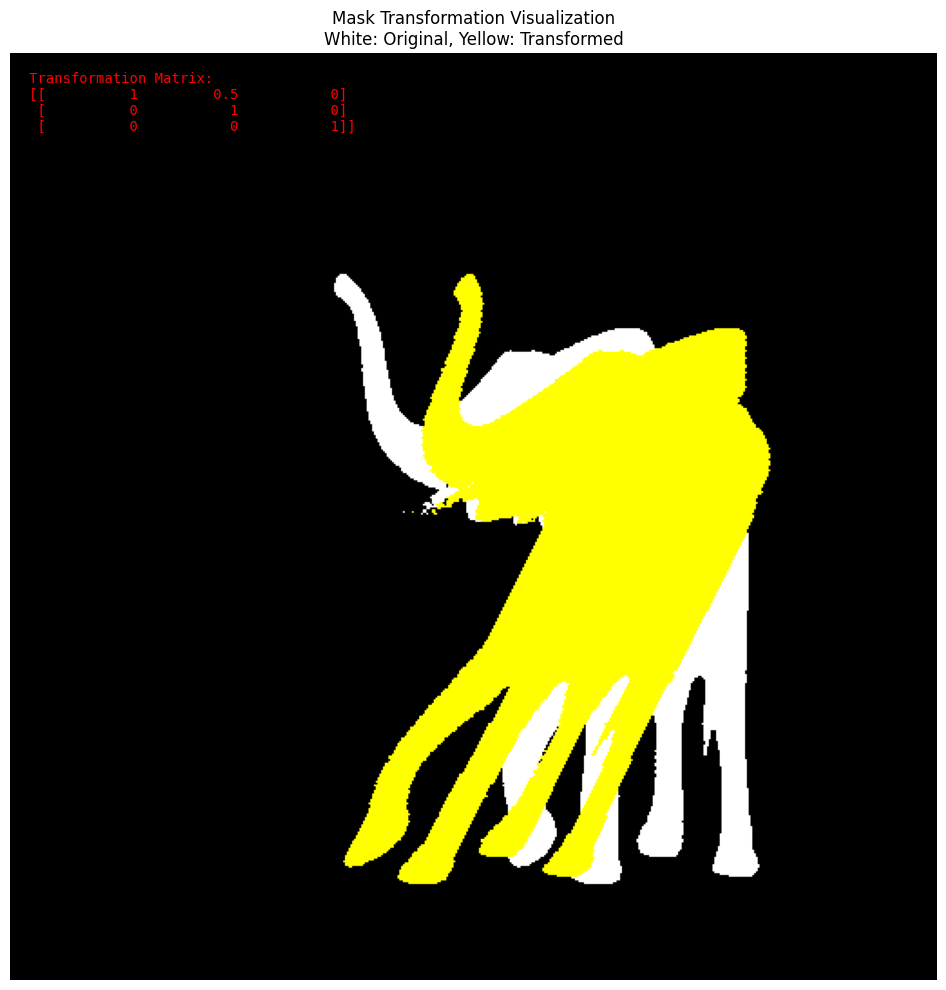

In [30]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

# Constants
img_name = "elephant"
output_dir = 'output'
MASK_FILE_NAME = "Elephant_binary_mask_0.png"
FILE_DESCRIPTION = "output/elephant_detection.txt"
TRANSFORMATION_MATRIX_FILE = f'output/{img_name}_transformation_matrix.npy'

# Load and validate transformation matrix
try:
    loaded_matrix = np.load(TRANSFORMATION_MATRIX_FILE)
    print("Loaded transformation matrix:")
    print(loaded_matrix)
except FileNotFoundError:
    raise FileNotFoundError(f"Could not load transformation matrix from {TRANSFORMATION_MATRIX_FILE}")

# Load and validate binary mask
mask_path = os.path.join(output_dir, MASK_FILE_NAME)
binary_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

if binary_mask is None:
    raise FileNotFoundError(f"Could not load binary mask from {mask_path}")

print("\nBinary Mask Shape:", binary_mask.shape)

# Get mask dimensions
height, width = binary_mask.shape

# Read object boundaries from detection file
with open(FILE_DESCRIPTION, 'r') as f:
    detection_text = f.read()

# Extract bounding box coordinates
bbox_line = [line for line in detection_text.split('\n') if 'Bounding Box' in line][0]
xmin = float(bbox_line.split('xmin=')[1].split(',')[0])
ymin = float(bbox_line.split('ymin=')[1].split(',')[0])
xmax = float(bbox_line.split('xmax=')[1].split(',')[0])
ymax = float(bbox_line.split('ymax=')[1].split(')')[0])

# Convert normalized coordinates to pixel coordinates
x_min = int(xmin * width)
x_max = int(xmax * width)
y_min = int(ymin * height)
y_max = int(ymax * height)

# Calculate object center
x_center = (x_min + x_max) // 2
y_center = (y_min + y_max) // 2

# Check if the loaded matrix contains rotation (by inspecting upper-left 2x2 submatrix)
rotation_only = (
    not np.isclose(loaded_matrix[0, 0], 1) or
    not np.isclose(loaded_matrix[1, 1], 1) or
    not np.isclose(loaded_matrix[0, 1], 0) or
    not np.isclose(loaded_matrix[1, 0], 0)
)

# Create translation matrices for centering (only if rotation is applied)
if rotation_only:
    T_to_origin = np.array([
        [1, 0, -x_center],
        [0, 1, -y_center],
        [0, 0, 1]
    ])

    T_from_origin = np.array([
        [1, 0, x_center],
        [0, 1, y_center],
        [0, 0, 1]
    ])

    # Compose final transformation
    final_transform = T_from_origin @ loaded_matrix @ T_to_origin
else:
    final_transform = loaded_matrix

# Generate coordinate grid
y, x = np.mgrid[0:height, 0:width]
coords = np.stack((x.flatten(), y.flatten(), np.ones_like(x.flatten())), axis=1).T  # Shape [3, N]

# Apply transformation to coordinates
transformed_coords = final_transform @ coords
transformed_coords /= transformed_coords[2]  # Normalize homogeneous coordinates

# Reshape back to image dimensions
transformed_x = transformed_coords[0].reshape(height, width)
transformed_y = transformed_coords[1].reshape(height, width)

# Remap the mask using transformed coordinates
transformed_mask = cv2.remap(binary_mask,
                             transformed_x.astype(np.float32),
                             transformed_y.astype(np.float32),
                             interpolation=cv2.INTER_NEAREST,
                             borderMode=cv2.BORDER_CONSTANT,
                             borderValue=0)

# Save the transformed mask
output_mask_path = f'output/{img_name}_transformed_mask.png'
cv2.imwrite(output_mask_path, transformed_mask)
print(f"\nTransformed mask saved to: {output_mask_path}")

# Visualization
plt.figure(figsize=(15, 10))

# Create RGB visualization
vis_image = np.zeros((height, width, 3), dtype=np.uint8)
vis_image[binary_mask > 0] = [255, 255, 255]  # Original mask in white
vis_image[transformed_mask > 0] = [255, 255, 0]  # Transformed mask in yellow

# Plot visualization
plt.imshow(vis_image)
plt.title('Mask Transformation Visualization\nWhite: Original, Yellow: Transformed')
plt.axis('off')

# Add transformation description
plt.text(0.02, 0.98, f"Transformation Matrix:\n{loaded_matrix}", 
         transform=plt.gca().transAxes,
         fontsize=10, color='red', 
         verticalalignment='top',
         fontfamily='monospace')

plt.tight_layout()
plt.savefig(f'output/{img_name}_transformation_vis.png')
plt.show()


# PART II - DRAWING WITH SDL

1. transform the original image into latent features.
2. exectue operations (addition, deletion, repositioning and attribute modification to these latent layers.)

Note: 
- latents in removed regions are re-initialized as gaussian noise.
- latenbt of newly added or modified objects are composited